## Initialization

### Imports

In [5]:
import lgbm.lgbm_optuna_column_filter as lgbm_fl
from statsmodels.tsa.api import SimpleExpSmoothing
import params_searchers.ts_splitter as ts_splitter
from sklearn import metrics
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

### Constants

In [6]:
TRAIN_DATE_FROM = '2015-01-08'
TRAIN_DATE_TO = '2023-02-05'
VAL_DATE_FROM = '2023-02-06'
VAL_DATE_TO = '2023-02-12'

CSV_JOINT_FILE = '../datasources/ds_joint/ds.csv'

POL_CODES = [7, 6001, 5, 8]
POL_NAMES = {7: "O3", 6001: "PM25", 5: "PM10", 8: "NO2"}

### Data load

In [7]:
df_joint = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')

In [8]:
_, y_val = ts_splitter.split_x_y_for_period(df=df_joint, index_cols='DatetimeEnd', y_value_col='AQI',                                                           dt_start=VAL_DATE_FROM, dt_end=VAL_DATE_TO)
_, y_train = ts_splitter.split_x_y_for_period(df=df_joint, index_cols='DatetimeEnd', y_value_col='AQI',                                                           dt_start=TRAIN_DATE_FROM, dt_end=TRAIN_DATE_TO)

In [9]:
df_res = pd.DataFrame(index=y_val.index)
df_res['AQI_VAL'] = y_val
display(df_res)

,AQI_VAL
DatetimeEnd,
2023-02-06,115
2023-02-07,139
2023-02-08,143
2023-02-09,127
2023-02-10,97
2023-02-11,74
2023-02-12,128


### Functions

In [10]:
def get_prediction(df, pol_id, best_params, best_categories, best_feat_count, use_lag_cols=True):
    use_aqi_cols = False if pol_id in [5, 6001] else True
    use_c_mean_cols = not use_aqi_cols

    o_helper, _, _, x_vl, _ = lgbm_fl.init_optuna(
        df=df, pol_id=pol_id, prediction_value_type=lgbm_fl.PredictionValueType.AQI,
        use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=True, use_weather_cols=True,
        train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO,
        default_params=best_params, default_category=best_categories, default_top_features_count=best_feat_count)

    score_train, score_val, _ = o_helper.run_model_and_eval(best_features_only=True, set_as_best_model=True)
    y_vl_pred = [int(round(x, 0)) for x in o_helper.predict_by_best_model(x_vl)]
    print(f'train score: {score_train}, val score: {score_val}')
    return y_vl_pred

## LGBM (+ weather, + lags, + gen lags) forecast

### O3

In [11]:
best_o3_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2600, 'num_leaves': 29, 'learning_rate': 0.12226624793990773, 'subsample': 0.8259925800585568, 'subsample_freq': 6, 'subsample_for_bin': 311124, 'min_child_samples': 13, 'reg_alpha': 0.1877661803380422, 'reg_lambda': 0.12122085900675779, 'max_depth': 7, 'max_bin': 346}
best_o3_categories =  ['season', 'month', 'year']
best_o3_features_count = 19

y_val_o3 = get_prediction(df=df_joint, pol_id=7, best_params=best_o3_params, best_categories=best_o3_categories, best_feat_count=best_o3_features_count)
df_res['AQI_O3_lgbm'] =  y_val_o3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
train score: 3.189026108017582, val score: 8.580380904072792


### PM 2.5

In [12]:
best_pm25_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
best_pm25_categories = ['month', 'weekday']
best_pm25_features_count = 73

y_val_pm25 = get_prediction(df=df_joint, pol_id=6001,best_params=best_pm25_params, best_categories=best_pm25_categories, best_feat_count=best_pm25_features_count,
                            use_lag_cols=False)

df_res['AQI_PM25_lgbm'] =  y_val_pm25

train score: 4.096338645025627, val score: 33.11449808343723


### PM 10

In [13]:
best_pm10_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1100, 'num_leaves': 55, 'learning_rate': 0.13336706254004013, 'subsample': 0.7110931352351093, 'subsample_freq': 0, 'subsample_for_bin': 194563, 'min_child_samples': 45, 'reg_alpha': 0.18017308854453762, 'reg_lambda': 0.8264670184761244, 'max_depth': 5, 'max_bin': 270}

best_pm10_categories =  ['season', 'weekday']
best_pm10_features_count = 31

y_val_pm10 = get_prediction(df=df_joint, pol_id=5, best_params=best_pm10_params, best_categories=best_pm10_categories, best_feat_count=best_pm10_features_count)

df_res['AQI_PM10_lgbm'] =  y_val_pm10

train score: 3.337251537037417, val score: 6.98974708460903


### NO2

In [14]:
best_no2_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2200, 'num_leaves': 140, 'learning_rate': 0.076297211673832, 'subsample': 0.9048416321209771, 'subsample_freq': 1, 'subsample_for_bin': 141792, 'min_child_samples': 48, 'reg_alpha': 0.31049100804293384, 'reg_lambda': 0.7272704696443957, 'max_depth': 4, 'max_bin': 307}

best_no2_categories =  ['season', 'month']
best_no2_features_count = 30
y_val_no2 = get_prediction(df=df_joint, pol_id=8, best_params=best_no2_params, best_categories=best_no2_categories, best_feat_count=best_no2_features_count)
df_res['AQI_NO2_lgbm'] =  y_val_no2

train score: 4.45541823885513, val score: 3.1020357213684866


### Gen AQI from best LGBM forecast

In [15]:
df_res['AQI_GEN_lgbm'] = df_res[['AQI_O3_lgbm', 'AQI_PM25_lgbm', 'AQI_PM10_lgbm', 'AQI_NO2_lgbm']].values.max(axis=1)
display(df_res)
score_lgbm_weather = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_GEN_lgbm'].values))
score_lgbm_weather

,AQI_VAL,AQI_O3_lgbm,AQI_PM25_lgbm,AQI_PM10_lgbm,AQI_NO2_lgbm,AQI_GEN_lgbm
DatetimeEnd,,,,,,
2023-02-06,115,19,98,22,30,98
2023-02-07,139,15,104,27,33,104
2023-02-08,143,19,103,27,33,103
2023-02-09,127,19,85,23,36,85
2023-02-10,97,19,73,20,36,73
2023-02-11,74,25,59,20,31,59
2023-02-12,128,18,86,20,33,86


32.60806210564673

## Arima forecast

### O3

### PM 2.5

### PM 10

### NO2

## Simple Mean forecast

In [16]:
df_res['AQI_mean'] = int(round(y_train.mean()))
score_mean = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_mean'].values))
score_mean

73.20519107276478

## Simple Exponential Smoothing forecasts

In [17]:
def ses_by_pols(alpha, pol_id):
    col_name = 'AQI_' + POL_NAMES[pol_id]
    _, y_val = ts_splitter.split_x_y_for_period(df=df_joint, index_cols='DatetimeEnd', y_value_col=col_name,                                                           dt_start=VAL_DATE_FROM, dt_end=VAL_DATE_TO)
    _, y_train = ts_splitter.split_x_y_for_period(df=df_joint, index_cols='DatetimeEnd', y_value_col=col_name,                                                           dt_start=TRAIN_DATE_FROM, dt_end=TRAIN_DATE_TO)
    ses = SimpleExpSmoothing(y_train)
    model_ses = ses.fit(smoothing_level = alpha, optimized = False)
    y_pred = model_ses.forecast(7)
    y_pred = [int(round(x)) for x in y_pred]
    score = math.sqrt(metrics.mean_squared_error(y_val.values, y_pred))
    print(f'Score for {POL_NAMES[pol_id]}: {score}')
    return y_pred

### alpha = 0.1

In [18]:
alpha = 0.1
for pol_id in POL_CODES:
    df_res[f'AQI_{POL_NAMES[pol_id]}_ses_a01']= ses_by_pols(alpha, pol_id)

df_res[f'AQI_ses_a01'] = df_res[['AQI_O3_ses_a01', 'AQI_PM25_ses_a01', 'AQI_PM10_ses_a01', 'AQI_NO2_ses_a01']].values.max(axis=1)
score_ses_a01 = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_ses_a01'].values))
score_ses_a01

Score for O3: 7.681145747868608
Score for PM25: 67.5288298221053
Score for PM10: 11.532562594670797
Score for NO2: 14.367622330384782


67.5288298221053

### alpha = 0.5

In [19]:
alpha = 0.5
for pol_id in POL_CODES:
    df_res[f'AQI_{POL_NAMES[pol_id]}_ses_a05']= ses_by_pols(alpha, pol_id)

df_res[f'AQI_ses_a05'] = df_res[['AQI_O3_ses_a05', 'AQI_PM25_ses_a05', 'AQI_PM10_ses_a05', 'AQI_NO2_ses_a05']].values.max(axis=1)
score_ses_a05 = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_ses_a05'].values))
score_ses_a05

Score for O3: 15.883504471171161
Score for PM25: 49.165899913310994
Score for PM10: 6.928203230275509
Score for NO2: 5.41162769282166


49.165899913310994

### alpha = 1

In [20]:
alpha = 1
for pol_id in POL_CODES:
    df_res[f'AQI_{POL_NAMES[pol_id]}_ses_a1']= ses_by_pols(alpha, pol_id)

df_res[f'AQI_ses_a1'] = df_res[['AQI_O3_ses_a1', 'AQI_PM25_ses_a1', 'AQI_PM10_ses_a1', 'AQI_NO2_ses_a1']].values.max(axis=1)
score_ses_a1 = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_ses_a1'].values))
score_ses_a1

Score for O3: 21.44094880629786
Score for PM25: 43.936642696371
Score for PM10: 6.447590912226719
Score for NO2: 4.750939756661683


43.936642696371

## Forecast

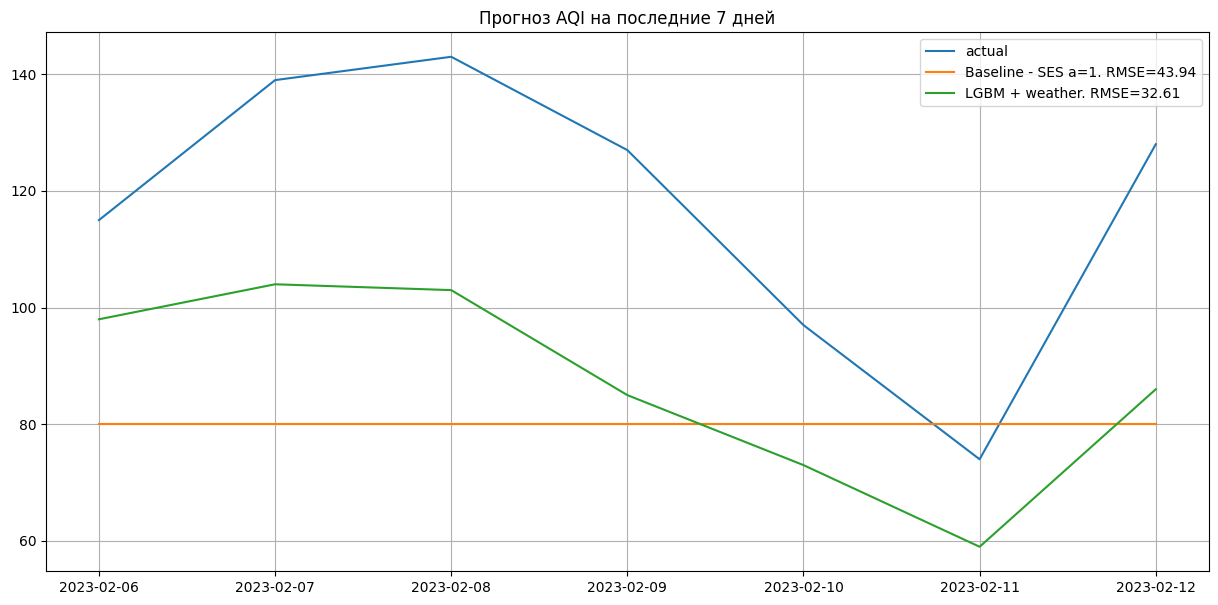

In [21]:
plt.figure(figsize=(15, 7))
plt.title(f"Прогноз AQI на последние 7 дней")
plt.plot(df_res['AQI_VAL'], label="actual")
plt.plot(df_res['AQI_ses_a1'], label="Baseline - SES a=1. RMSE=%.2f" % score_ses_a1)
plt.plot(df_res['AQI_GEN_lgbm'], label="LGBM + weather. RMSE=%.2f" % score_lgbm_weather)
#plt.plot(df_res['AQI_ses_a01'], label="SES a=0.1. RMSE=%.2f" % score_ses_a01)
#plt.plot(df_res['AQI_ses_a05'], label="SES a=0.5. RMSE=%.2f" % score_ses_a05)
#plt.plot(df_res['AQI_mean'], label="DF.MEAN. RMSE=%.2f" % score_mean)
plt.plot()
plt.legend()
plt.grid(True)
plt.show()